<a href="https://colab.research.google.com/github/gregory-m-mullen/logp_ml/blob/main/logp_ml_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Methods for Predicting logP of Molecules

This notebook runs through training of several machine learning models for predicting the solubility parameter (logP) of a molecule from it's molecular structure. It uses the [RDKit](https://www.rdkit.org/docs/Overview.html#what-is-it) and [DeepChem](https://deepchem.io/about) libraries to create fingerprint representations of molecules and scikit-learn and XGBoost to establish and train the models for predicting logP.

## Data Import/Preprocessing

In [ ]:
!pip install --pre deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.8/812.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 54.6 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import pandas as pd
import deepchem as dc
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import requests

In [ ]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

The dataset we are going to use for this project comes from the [ZINC database](https://zinc.docking.org/). I have a preprocessed csv file stored in Google Drive that I have made available for anyone to download.

In [ ]:
file_id = '1k1_o39n5UOAKr1ESQfAdo5hopAgyw33W'
destination = 'smiles_mw_logp.csv'
download_file_from_google_drive(file_id, destination)

df_all = pd.read_csv(
    'smiles_mw_logp.csv',
    index_col='smiles'
    ).sample(frac=1, random_state=2)

In [ ]:
def define_dataset(df):
  df['mol_from_smiles'] = df.index.values
  df['mol_from_smiles'] = df['mol_from_smiles'].apply(lambda x: Chem.MolFromSmiles(x))
  df = df[~df['mol_from_smiles'].isnull()]

  featurizer = dc.feat.CircularFingerprint()
  features = [featurizer._featurize(x) for x in df.mol_from_smiles.values]

  df = df.drop(['mol_from_smiles'], axis=1)

  features_train, features_test, targets_train, targets_test = train_test_split(features, df, test_size=0.1, random_state=2)

  return features_train, features_test, targets_train, targets_test

In [ ]:
features_train, features_test, targets_train, targets_test = define_dataset(df_all)

dataset_train = dc.data.NumpyDataset(X=features_train, y=targets_train)
dataset_test = dc.data.NumpyDataset(X=features_test, y=targets_test)

## Model Fitting

In [ ]:
def fit_model(model, parameters, features_test, targets_test):
    reg = GridSearchCV(model, parameters, scoring='r2')
    reg.fit(features_train, targets_train)
    return reg

In [ ]:
def assess_model(model, parameters, features_test, targets_test):
  print(model.best_estimator_)

  df_test = pd.DataFrame(data=model.predict(features_test), index=targets_test.index, columns=['Predicted'])
  df_test['Actual'] = targets_test['logp']
  df_test['Train_Test'] = 'Test'

  error_test = ((df_test['Actual']-df_test['Predicted'])**2).apply(np.sqrt).mean()

  df_train = pd.DataFrame(data=model.predict(features_train), index=targets_train.index, columns=['Predicted'])
  df_train['Actual'] = targets_train['logp']
  df_train['Train_Test'] = 'Train'

  error_train = ((df_train['Actual']-df_train['Predicted'])**2).apply(np.sqrt).mean()

  print('RMS error (train): ' + str(error_train))
  print('RMS error (test): ' + str(error_test))

  df_plot = pd.concat([df_test,df_train])

  sns.set(context='paper', font_scale=1.5)
  sns.lmplot(data=df_plot, x='Predicted', y='Actual', hue='Train_Test', height=6, fit_reg=False)
  plt.axline((0, 0), slope=1, color='red', linestyle=(0, (5, 5)))
  plt.show()

###Linear regression models

####Ridge regression

Ridge(alpha=10)
RMS error (train): 0.18959217047045324
RMS error (test): 0.19824547317726035


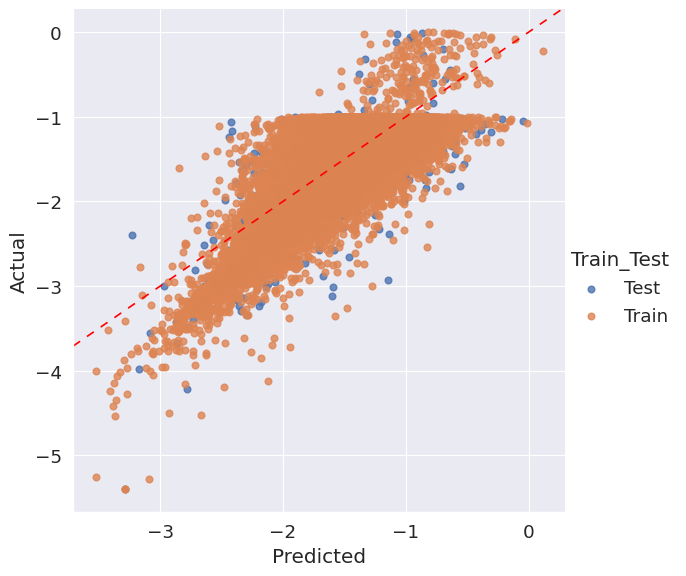

In [ ]:
from sklearn.linear_model import Ridge

parameters = {'alpha':[0.001,0.01,0.1,1,10,100]}
model = Ridge()

model = fit_model(model, parameters, features_test, targets_test)

assess_model(model, parameters, features_test, targets_test)

####Lasso

Lasso(alpha=1e-05)
RMS error (train): 0.18926130424350304
RMS error (test): 0.198227639783604


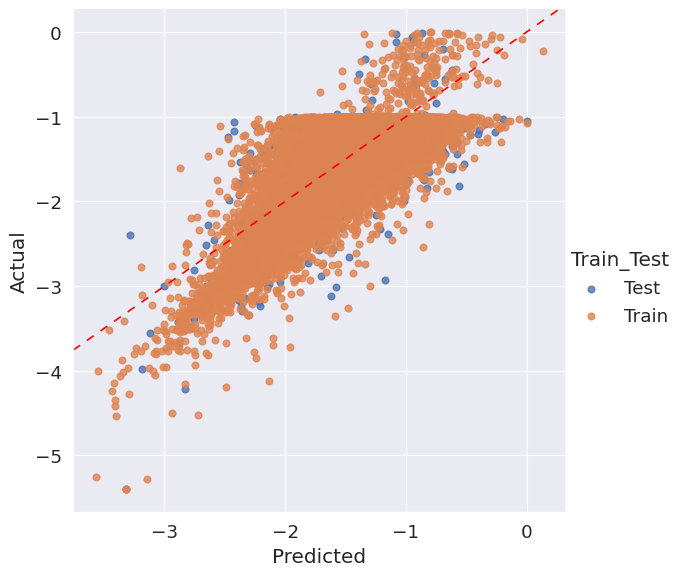

In [ ]:
from sklearn.linear_model import Lasso

parameters = {'alpha':[1e-5,1e-4,0.001,0.01,0.1]}
model = Lasso()

model = fit_model(model, parameters, features_test, targets_test)

assess_model(model, parameters, features_test, targets_test)

###Ensemble models

####Random forest

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

parameters = {'n_estimators':[10,100,1000],'max_features':[None,'sqrt']}
model = ExtraTreesRegressor()

model = fit_model(model, parameters, features_test, targets_test)

assess_model(model, parameters, features_test, targets_test)

####XGBoost

In [ ]:
import xgboost as xgb

!mkdir 'xgboost'

def fit_model_xgb(n_estimators_list, max_depth_list, features_train, targets_train):
  for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
      model = xgb.XGBRegressor(
          tree_method='gpu_hist',
          gpu_id=0,
          objective='reg:squarederror',
          n_estimators=n_estimators,
          max_depth=max_depth,
          )

      model.fit(features_train, targets_train)

      model.save_model(
          './xgboost'+'//'+str(n_estimators)+'_'+str(max_depth)+'.model'
          )

In [ ]:
n_estimators_list = [1000,2000]
max_depth_list = [1,2,4,8,16]

fit_model_xgb(n_estimators_list, max_depth_list, features_train, targets_train)

In [ ]:
def assess_model_xgb(
    n_estimators_list,
    max_depth_list,
    features_test,
    targets_test,
    hue='n_estimators'
    ):

  df_all = pd.DataFrame()
  df_corr = pd.DataFrame(columns=['Train','Test'])
  df_corr.index.name = 'Model'
  for n_estimators in n_estimators_list:
      for max_depth in max_depth_list:
          try:
              model = xgb.XGBRegressor()
              model.load_model('./xgboost'+'//'+str(n_estimators)+'_'+str(max_depth)+'.model')

              df_test = pd.DataFrame(data=model.predict(features_test), index=targets_test.index, columns=['Predicted'])
              df_test['Actual'] = targets_test['logp']
              df_test['Train_Test'] = 'Test'

              error_test = ((df_test['Actual']-df_test['Predicted'])**2).apply(np.sqrt).mean()

              df_train = pd.DataFrame(data=model.predict(features_train), index=targets_train.index, columns=['Predicted'])
              df_train['Actual'] = targets_train['logp']
              df_train['Train_Test'] = 'Train'

              error_train = ((df_train['Actual']-df_train['Predicted'])**2).apply(np.sqrt).mean()

              df_corr.loc[str(n_estimators)+'_'+str(max_depth),'Train'] = error_train
              df_corr.loc[str(n_estimators)+'_'+str(max_depth),'Test'] = error_test
              df_corr.loc[str(n_estimators)+'_'+str(max_depth),'n_estimators'] = n_estimators
              df_corr.loc[str(n_estimators)+'_'+str(max_depth),'max_depth'] = max_depth

          except Exception as e:
              print(e)
              pass
  print(df_corr)
  sns.set(context='paper',font_scale=1.5)
  sns.lmplot(data=df_corr, x='Train', y='Test', hue=hue, fit_reg=False)
  plt.show()
  return df_corr

            Train      Test  n_estimators  max_depth
Model                                               
1000_1   0.237487  0.238513        1000.0        1.0
1000_2   0.188684  0.198885        1000.0        2.0
1000_4   0.113854  0.163285        1000.0        4.0
1000_8   0.029153  0.164638        1000.0        8.0
1000_16   0.00106  0.212572        1000.0       16.0
2000_1   0.221529  0.224256        2000.0        1.0
2000_2   0.160253  0.178801        2000.0        2.0
2000_4   0.078454  0.147099        2000.0        4.0
2000_8   0.010452  0.162081        2000.0        8.0
2000_16   0.00106  0.212572        2000.0       16.0


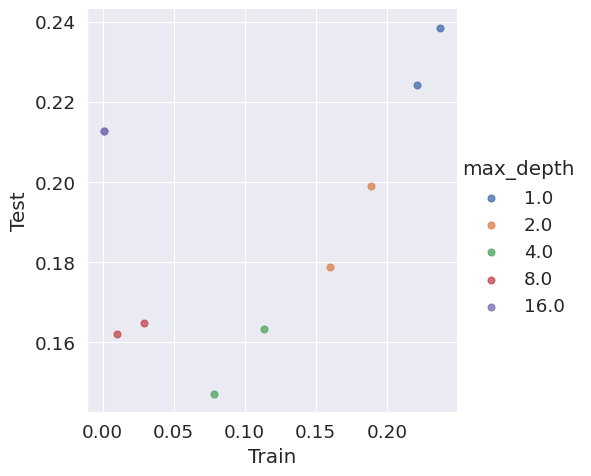

In [ ]:
n_estimators_list = [1000,2000]
max_depth_list = [1,2,4,8,16]

df_corr = assess_model_xgb(n_estimators_list, max_depth_list, features_test, targets_test, hue='max_depth')

In [ ]:
n_estimators_list = [4000,8000,16000]
max_depth_list = [4]

fit_model_xgb(n_estimators_list, max_depth_list, features_train, targets_train)

            Train      Test  n_estimators  max_depth
Model                                               
1000_4   0.113854  0.163285        1000.0        4.0
2000_4   0.078454  0.147099        2000.0        4.0
4000_4   0.047479  0.136949        4000.0        4.0
8000_4    0.02296  0.131764        8000.0        4.0
16000_4  0.007499  0.129956       16000.0        4.0


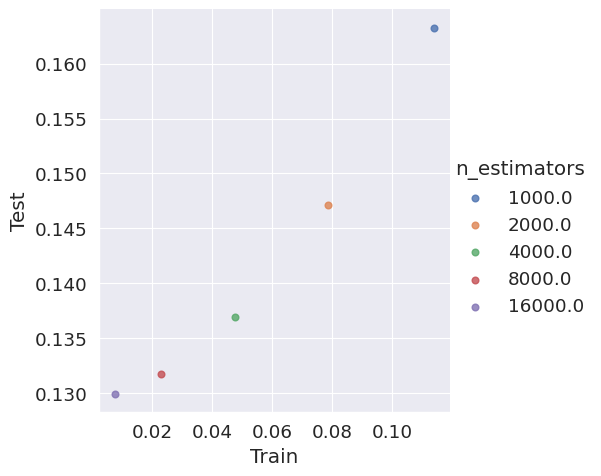

In [ ]:
n_estimators_list = [1000,2000,4000,8000,16000]
max_depth_list = [4]

df_corr = assess_model_xgb(n_estimators_list, max_depth_list, features_test, targets_test)

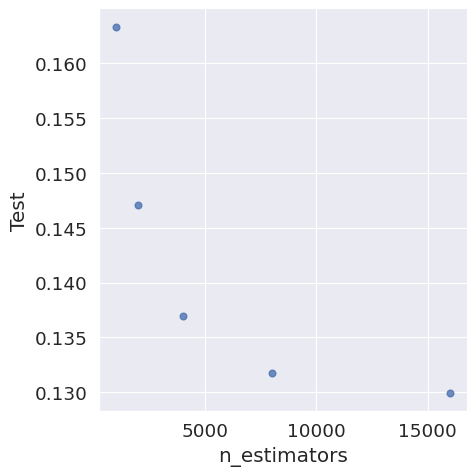

In [ ]:
sns.lmplot(data=df_corr, x='n_estimators', y='Test', fit_reg=False)
plt.show()

XGBoost does the best out of this set of algorithms, but it still overfits the data pretty badly.

Link to graph convolution neural network method for predicting logP.